In [ ]:
import pandas as pd
from tensorflow.keras.utils import get_file
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import Normalizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

try:
    path = get_file('kdd-with-columns.csv', origin=\
    'https://github.com/jeffheaton/jheaton-ds2/raw/main/'\
    'kdd-with-columns.csv',archive_format=None)
except:
    print('Error downloading')
    raise
    
print(path) 

# Origional file: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to 
# sample only 10% of the dataset
df.dropna(inplace=True,axis=1) 
# For now, just drop NA's (rows with missing values)


# display 5 rows
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)
df

/root/.keras/datasets/kdd-with-columns.csv
Read 494021 rows.


,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,tcp,...,0.0,normal.
1,0,tcp,...,0.0,normal.
...,...,...,...,...,...
494019,0,tcp,...,0.0,normal.
494020,0,tcp,...,0.0,normal.


In [ ]:
# Encode a numeric column as zscores
zscore_val = {}
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    
    if sd is None:
        sd = df[name].std()
    
    zscore_val[name] = {"mean":mean,"sd":sd}
    df[name] = (df[name] - mean) / sd

    
    
# Encode text values to dummy variables(i.e. [1,0,0],
# [0,1,0],[0,0,1] for red,green,blue)
encode_column = {}

def encode_text_dummy(df, name):
    
    dummies = pd.get_dummies(df[name])
    encode_column[name] = dummies.columns
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Now encode the feature vector

pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

for name in df.columns:
  if name == 'outcome':
    pass
  elif name in ['protocol_type','service','flag','land','logged_in',
                'is_host_login','is_guest_login']:
    encode_text_dummy(df,name)
  else:
    encode_numeric_zscore(df,name)    

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]


# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
outcome_=df['outcome']
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

In [ ]:
from collections import Counter
Counter(outcome_)

Counter({'back.': 2203,
         'buffer_overflow.': 30,
         'ftp_write.': 8,
         'guess_passwd.': 53,
         'imap.': 12,
         'ipsweep.': 1247,
         'land.': 21,
         'loadmodule.': 9,
         'multihop.': 7,
         'neptune.': 107201,
         'nmap.': 231,
         'normal.': 97278,
         'perl.': 3,
         'phf.': 4,
         'pod.': 264,
         'portsweep.': 1040,
         'rootkit.': 10,
         'satan.': 1589,
         'smurf.': 280790,
         'spy.': 2,
         'teardrop.': 979,
         'warezclient.': 1020,
         'warezmaster.': 20})

In [ ]:
train_col =x_columns
train_col

Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
       ...
       'flag-S3', 'flag-SF', 'flag-SH', 'land-0', 'land-1', 'logged_in-0',
       'logged_in-1', 'is_host_login-0', 'is_guest_login-0',
       'is_guest_login-1'],
      dtype='object', length=120)

In [ ]:
encode_column

{'flag': Index(['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF',
        'SH'],
       dtype='object'),
 'is_guest_login': Int64Index([0, 1], dtype='int64'),
 'is_host_login': Int64Index([0], dtype='int64'),
 'land': Int64Index([0, 1], dtype='int64'),
 'logged_in': Int64Index([0, 1], dtype='int64'),
 'protocol_type': Index(['icmp', 'tcp', 'udp'], dtype='object'),
 'service': Index(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf',
        'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i',
        'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'hostnames',
        'http', 'http_443', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap',
        'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns',
        'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump',
        'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje',
        'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systa

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.               2203
buffer_overflow.      30
                    ... 
warezclient.        1020
warezmaster.          20
Name: outcome, Length: 23, dtype: int64

In [ ]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

In [ ]:
y_test.shape

(123506, 23)

In [ ]:
x_test.shape

(123506, 120)

In [ ]:
y_train.shape

(370515, 23)

In [ ]:
x_train.shape

(370515, 120)

In [ ]:
dnn = Sequential()
dnn.add(Dense(1024,input_dim=120,activation='relu'))  
dnn.add(Dropout(0.01))
dnn.add(Dense(23))
dnn.add(Activation('softmax'))

In [ ]:
dnn.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
checkpointer = callbacks.ModelCheckpoint(filepath="checkpoint/dnn/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger('logs/dnnanalysis.csv',separator=',', append=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=100)
history = dnn.fit(x_train, y_train, epochs=5000,validation_data=(x_test, y_test),callbacks=[checkpointer,csv_logger,es],verbose=2)
dnn.save("results/dnn/dnn_model.h5")

Epoch 1/5000

Epoch 1: val_accuracy improved from -inf to 0.99892, saving model to checkpoint/dnn/checkpoint-01.hdf5
11579/11579 - 48s - loss: 0.0174 - accuracy: 0.9981 - val_loss: 0.0108 - val_accuracy: 0.9989 - 48s/epoch - 4ms/step
Epoch 2/5000

Epoch 2: val_accuracy improved from 0.99892 to 0.99908, saving model to checkpoint/dnn/checkpoint-02.hdf5
11579/11579 - 76s - loss: 0.0105 - accuracy: 0.9990 - val_loss: 0.0089 - val_accuracy: 0.9991 - 76s/epoch - 7ms/step
Epoch 3/5000

Epoch 3: val_accuracy did not improve from 0.99908
11579/11579 - 45s - loss: 0.0079 - accuracy: 0.9991 - val_loss: 0.0116 - val_accuracy: 0.9990 - 45s/epoch - 4ms/step
Epoch 4/5000

Epoch 4: val_accuracy did not improve from 0.99908
11579/11579 - 49s - loss: 0.0077 - accuracy: 0.9992 - val_loss: 0.0161 - val_accuracy: 0.9986 - 49s/epoch - 4ms/step
Epoch 5/5000

Epoch 5: val_accuracy improved from 0.99908 to 0.99920, saving model to checkpoint/dnn/checkpoint-05.hdf5
11579/11579 - 52s - loss: 0.0128 - accuracy: 

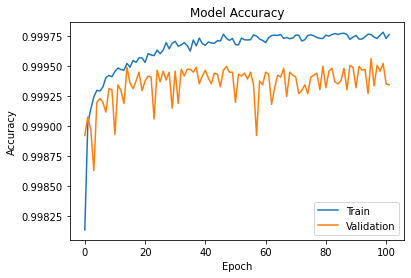

In [46]:
plt.plot(dnn.history.history['accuracy'])
plt.plot(dnn.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

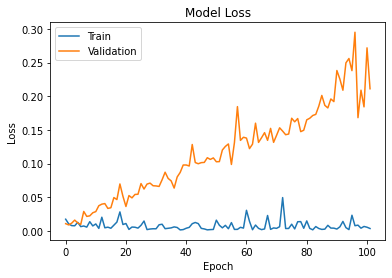

In [47]:
plt.plot(dnn.history.history['loss'])
plt.plot(dnn.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
def input_data(df):
    """
    data should be list of dictionary format
    """
   
    def encode_numeric_zscore_predict(df, name, mean=None, sd=None):
       
        df[name] = (df[name] - zscore_val[name]["mean"]) / zscore_val[name]["sd"]

    def encode_text_dummy_predict(df, name):
        
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = f"{name}-{x}"
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)
        # Get missing columns in the training test
        

    

    for name in df.columns:
        if name == 'outcome':
            pass
        elif name in ['protocol_type','service','flag','land','logged_in',
                        'is_host_login','is_guest_login']:
            encode_text_dummy_predict(df,name)
        else:
            encode_numeric_zscore_predict(df,name)    

    # display 5 rows

    df.fillna(0)

    
    # Convert to numpy - Classification
    x_columns = df.columns.drop('outcome')
    missing_cols = set( train_col ) - set( x_columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        df[c] = 0
    print(df.head())
    # Ensure the order of column in the test set is in the same order than in train set

    #ToDo: if output is not presemt ,comment this line
    dummies = pd.get_dummies(df['outcome'])
    
    df = df[train_col]
    x_columns = df.columns
    x = df[x_columns].values

    # dummies = pd.get_dummies(df['outcome']) # Classification
    #ToDo: if output is not presemt ,comment this line
    outcomes = dummies.columns
    #ToDo: if output is not presemt ,comment this line
    num_classes = len(outcomes)
    #ToDo: if output is not presemt ,comment this line
    y = dummies.values
    #ToDo: if output is not presemt,returm only x
    return x,y


In [33]:
df = pd.read_csv(path)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to 
# sample only 10% of the dataset
df.dropna(inplace=True,axis=1) 
# For now, just drop NA's (rows with missing values)


# display 5 rows
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)
df

Read 494021 rows.


,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,tcp,...,0.0,normal.
1,0,tcp,...,0.0,normal.
...,...,...,...,...,...
494019,0,tcp,...,0.0,normal.
494020,0,tcp,...,0.0,normal.


In [34]:
x,y = input_data(df)


   duration  src_bytes  ...  is_guest_login-0  is_guest_login-1
0 -0.067792  -0.002879  ...                 1                 0
1 -0.067792  -0.002820  ...                 1                 0
2 -0.067792  -0.002824  ...                 1                 0
3 -0.067792  -0.002840  ...                 1                 0
4 -0.067792  -0.002842  ...                 1                 0

[5 rows x 122 columns]


In [35]:
from keras.models import load_model

loaded_model = load_model("results/dnn/dnn_model.h5")
loss, accuracy = loaded_model.evaluate(x, y)

15439/15439 [==============================] - 37s 2ms/step - loss: 0.0548 - accuracy: 0.9997


In [36]:
from sklearn.metrics import confusion_matrix,f1_score

In [37]:
#ToDo:if only x

#predict
out = loaded_model.predict(x)

In [38]:
predict_class = [np.argmax(each) for each in out]

In [39]:
set(predict_class)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22}

In [40]:
confusion_mtx = confusion_matrix([np.argmax(each) for each in y],predict_class)

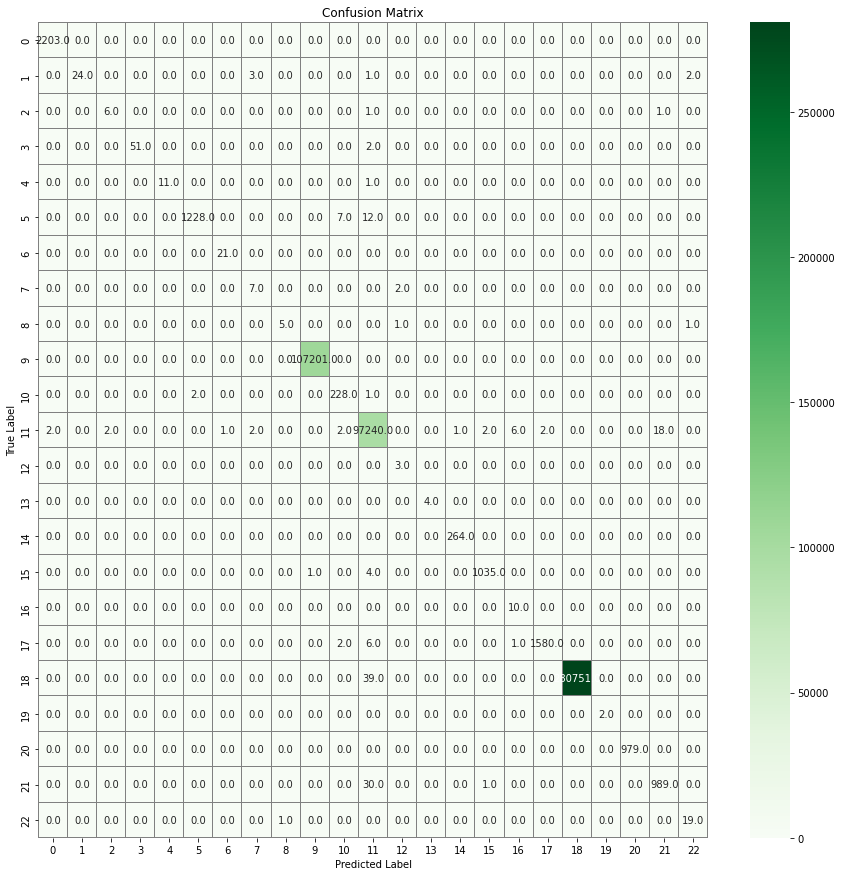

In [41]:
# plot the confusion matrix
import seaborn as sns
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [42]:
f1_score([np.argmax(each) for each in y],predict_class,average='micro')

0.999676127128199

In [43]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision_score([np.argmax(each) for each in y],predict_class,average='micro')


0.999676127128199

In [44]:
recall_score([np.argmax(each) for each in y],predict_class,average='micro')

0.999676127128199

In [45]:
from sklearn.metrics import classification_report
print(classification_report([np.argmax(each) for each in y],predict_class, target_names=outcomes))

                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00      2203
buffer_overflow.       1.00      0.80      0.89        30
      ftp_write.       0.75      0.75      0.75         8
   guess_passwd.       1.00      0.96      0.98        53
           imap.       1.00      0.92      0.96        12
        ipsweep.       1.00      0.98      0.99      1247
           land.       0.95      1.00      0.98        21
     loadmodule.       0.58      0.78      0.67         9
       multihop.       0.83      0.71      0.77         7
        neptune.       1.00      1.00      1.00    107201
           nmap.       0.95      0.99      0.97       231
         normal.       1.00      1.00      1.00     97278
           perl.       0.50      1.00      0.67         3
            phf.       1.00      1.00      1.00         4
            pod.       1.00      1.00      1.00       264
      portsweep.       1.00      1.00      1.00      1040
        rootk